# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Multiple Introduction

In [164]:
import sys
sys.path.append('../../')

In [165]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from ML_Regression import ML_Regression
from util.Save_result_return import save_to_csv

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [167]:
from backtesting import Strategy

## Getting the Data

In [168]:
XAUUSD = load_data()

In [169]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [170]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


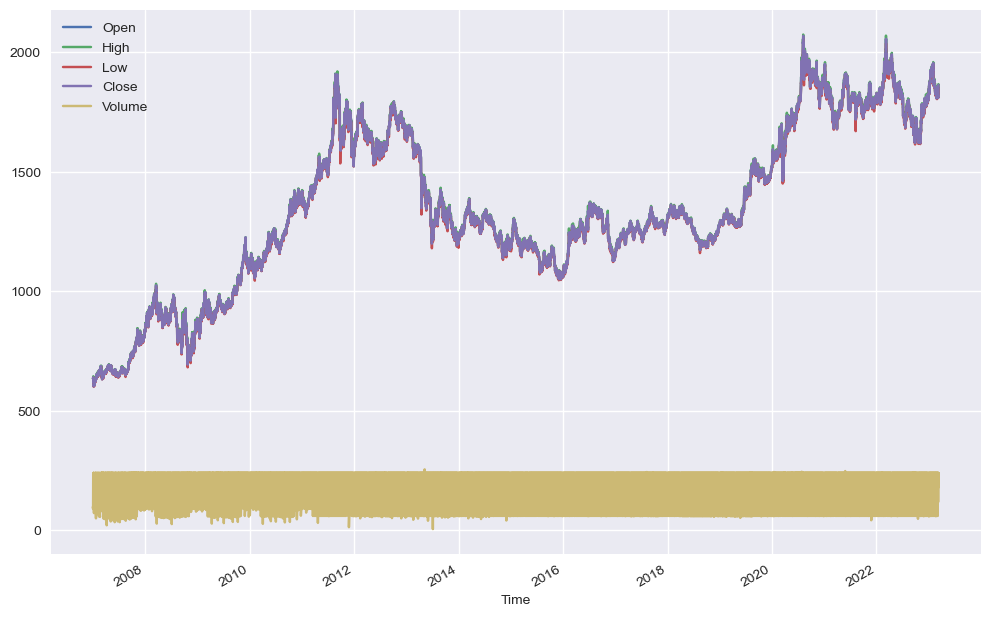

In [171]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [172]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [173]:
strategy = Mutiple_Regression
account_size = 2000

In [174]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=1000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        self.Predict()
        result_test = self.Backtest(self.data_test)
       
        return result_train, result_test

## TF D1

In [175]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [176]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [177]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [178]:
train

Start                     2007-01-08 00:00:00
End                       2020-12-30 00:00:00
Duration                   5105 days 00:00:00
Exposure Time [%]                   99.954097
Equity Final [$]                     2379.607
Equity Peak [$]                      2406.765
Return [%]                           137.9607
Buy & Hold Return [%]                211.0994
Return (Ann.) [%]                    5.142015
Volatility (Ann.) [%]               11.839646
Sharpe Ratio                         0.434305
Sortino Ratio                        0.650073
Calmar Ratio                         0.149844
Max. Drawdown [%]                  -34.315852
Avg. Drawdown [%]                   -2.678768
Max. Drawdown Duration     2662 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                 1265
Win Rate [%]                        52.332016
Best Trade [%]                      10.617556
Worst Trade [%]                    -11.057102
Avg. Trade [%]                    

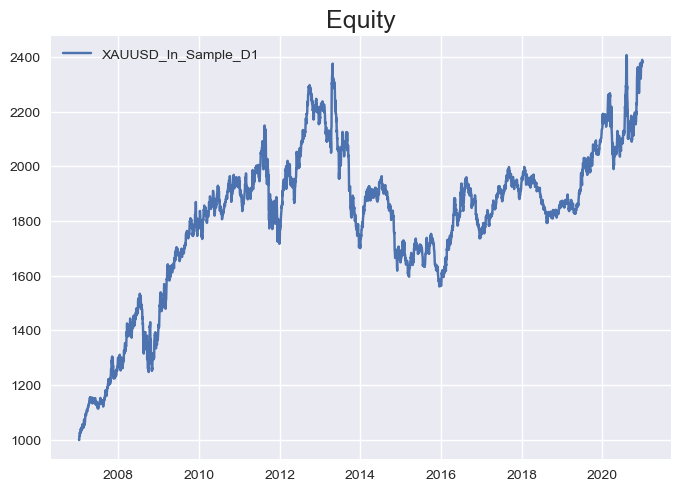

In [179]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [180]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                      879.407
Equity Peak [$]                      1407.593
Return [%]                           -12.0593
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                   -3.234246
Volatility (Ann.) [%]               24.641894
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -44.400903
Avg. Drawdown [%]                    -8.77139
Max. Drawdown Duration      391 days 00:00:00
Avg. Drawdown Duration       72 days 00:00:00
# Trades                                  284
Win Rate [%]                        48.239437
Best Trade [%]                       5.671401
Worst Trade [%]                     -5.389095
Avg. Trade [%]                    

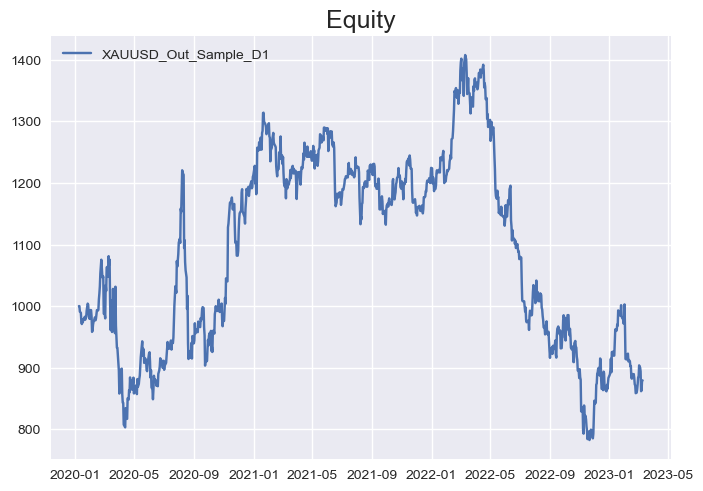

In [181]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [182]:
filename_train = f'result_{TF}_In_Sample.csv'

In [183]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [184]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [185]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H4

In [186]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [187]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [188]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [189]:
train

Start                     2007-01-02 00:00:00
End                       2020-12-31 16:00:00
Duration                   5112 days 16:00:00
Exposure Time [%]                   99.991098
Equity Final [$]                     5484.836
Equity Peak [$]                      5507.017
Return [%]                           448.4836
Buy & Hold Return [%]              197.611557
Return (Ann.) [%]                   10.326932
Volatility (Ann.) [%]                7.115859
Sharpe Ratio                         1.451256
Sortino Ratio                        2.562089
Calmar Ratio                         0.865797
Max. Drawdown [%]                  -11.927662
Avg. Drawdown [%]                   -0.513844
Max. Drawdown Duration      595 days 12:00:00
Avg. Drawdown Duration        7 days 16:00:00
# Trades                                 9675
Win Rate [%]                        53.157623
Best Trade [%]                       6.728522
Worst Trade [%]                     -7.592692
Avg. Trade [%]                    

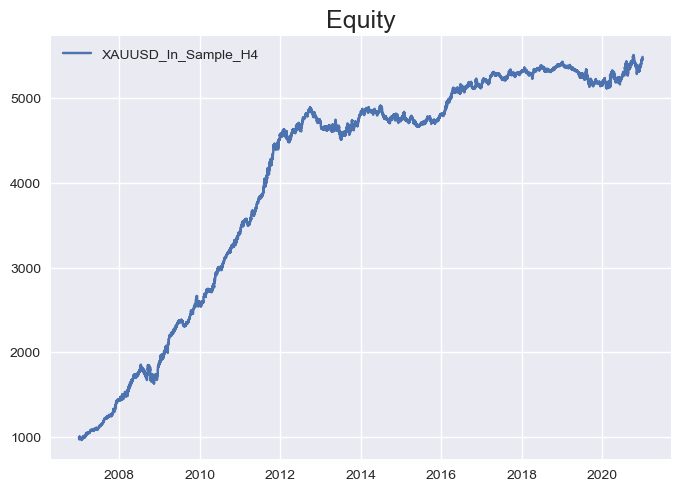

In [190]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [191]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                      959.243
Equity Peak [$]                      1408.253
Return [%]                            -4.0757
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                   -1.053596
Volatility (Ann.) [%]               23.036518
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -43.194156
Avg. Drawdown [%]                   -4.067098
Max. Drawdown Duration      756 days 20:00:00
Avg. Drawdown Duration       31 days 05:00:00
# Trades                                 2192
Win Rate [%]                        51.596715
Best Trade [%]                       4.311875
Worst Trade [%]                      -5.36415
Avg. Trade [%]                    

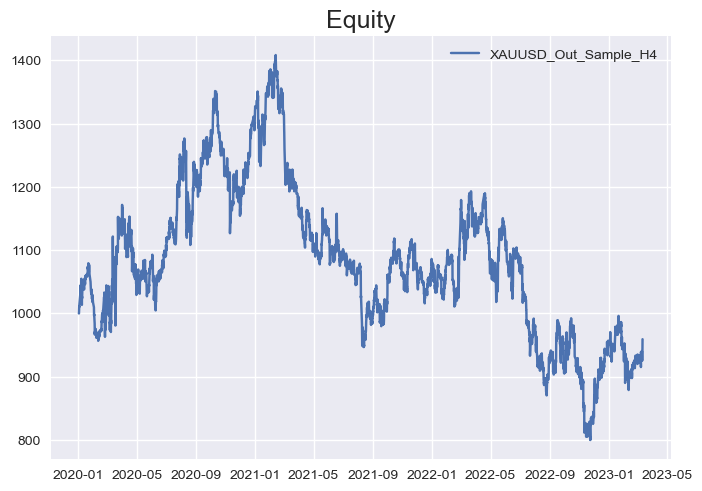

In [192]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [193]:
filename_train = f'result_{TF}_In_Sample.csv'

In [194]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [195]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [196]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H1

In [197]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [198]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [199]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [200]:
train

Start                     2007-01-01 06:00:00
End                       2020-12-31 20:00:00
Duration                   5113 days 14:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                       2560.3
Equity Peak [$]                      2706.136
Return [%]                             156.03
Buy & Hold Return [%]              198.974336
Return (Ann.) [%]                    5.577833
Volatility (Ann.) [%]               11.319114
Sharpe Ratio                          0.49278
Sortino Ratio                        0.777252
Calmar Ratio                         0.188359
Max. Drawdown [%]                  -29.612762
Avg. Drawdown [%]                   -0.646159
Max. Drawdown Duration     3245 days 17:00:00
Avg. Drawdown Duration       12 days 19:00:00
# Trades                                23641
Win Rate [%]                         54.51969
Best Trade [%]                       6.254102
Worst Trade [%]                     -8.827432
Avg. Trade [%]                    

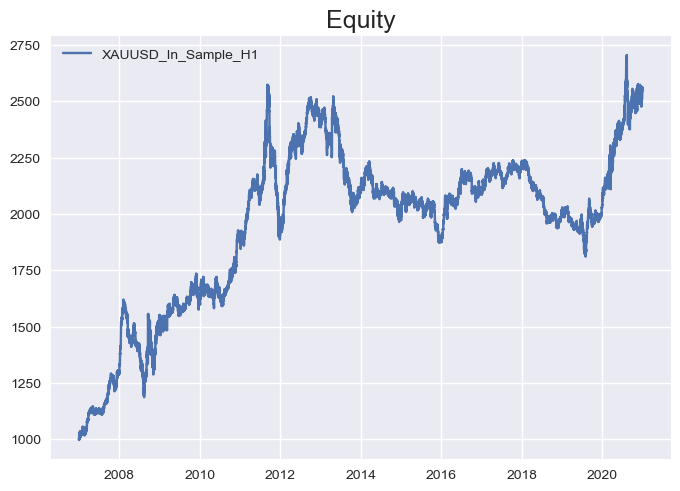

In [201]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [202]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                     1679.688
Equity Peak [$]                       1753.56
Return [%]                            67.9688
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                   13.601613
Volatility (Ann.) [%]               21.251046
Sharpe Ratio                         0.640044
Sortino Ratio                        1.066482
Calmar Ratio                         0.678064
Max. Drawdown [%]                  -20.059469
Avg. Drawdown [%]                   -1.478861
Max. Drawdown Duration      524 days 21:00:00
Avg. Drawdown Duration        9 days 03:00:00
# Trades                                 5426
Win Rate [%]                        54.902322
Best Trade [%]                       3.133816
Worst Trade [%]                     -4.748712
Avg. Trade [%]                    

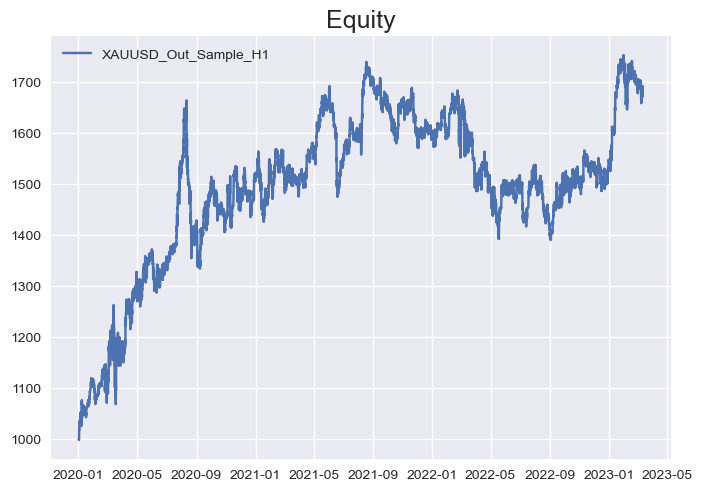

In [203]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [204]:
filename_train = f'result_{TF}_In_Sample.csv'

In [205]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [206]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [207]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M30

In [208]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [209]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [210]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [211]:
train

Start                     2007-01-01 03:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 18:00:00
Exposure Time [%]                   99.998819
Equity Final [$]                      3402.66
Equity Peak [$]                      3533.399
Return [%]                            240.266
Buy & Hold Return [%]              198.691869
Return (Ann.) [%]                    7.308003
Volatility (Ann.) [%]                9.041659
Sharpe Ratio                         0.808259
Sortino Ratio                        1.274886
Calmar Ratio                         0.412639
Max. Drawdown [%]                  -17.710384
Avg. Drawdown [%]                   -0.406069
Max. Drawdown Duration     2624 days 01:00:00
Avg. Drawdown Duration        4 days 23:33:00
# Trades                                64273
Win Rate [%]                         56.66454
Best Trade [%]                       3.114064
Worst Trade [%]                     -5.821422
Avg. Trade [%]                    

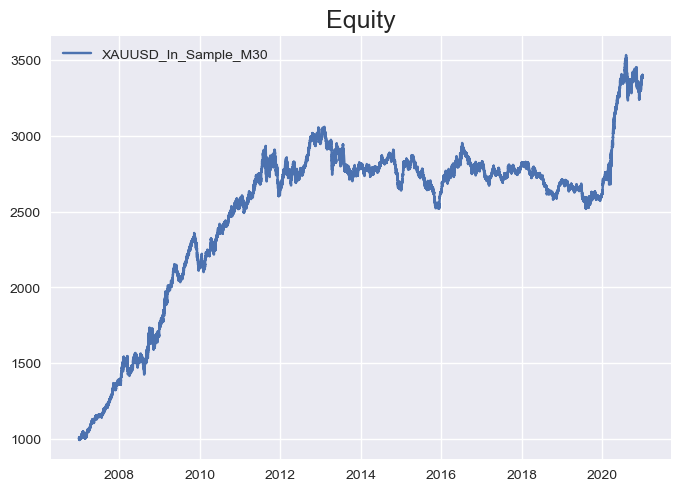

In [212]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [213]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                     2565.689
Equity Peak [$]                      2599.732
Return [%]                           156.5689
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                   26.781118
Volatility (Ann.) [%]               19.440249
Sharpe Ratio                         1.377612
Sortino Ratio                        2.750721
Calmar Ratio                          1.70367
Max. Drawdown [%]                  -15.719659
Avg. Drawdown [%]                    -0.62698
Max. Drawdown Duration      282 days 01:30:00
Avg. Drawdown Duration        2 days 19:40:00
# Trades                                14839
Win Rate [%]                         56.99845
Best Trade [%]                       2.889619
Worst Trade [%]                     -4.987939
Avg. Trade [%]                    

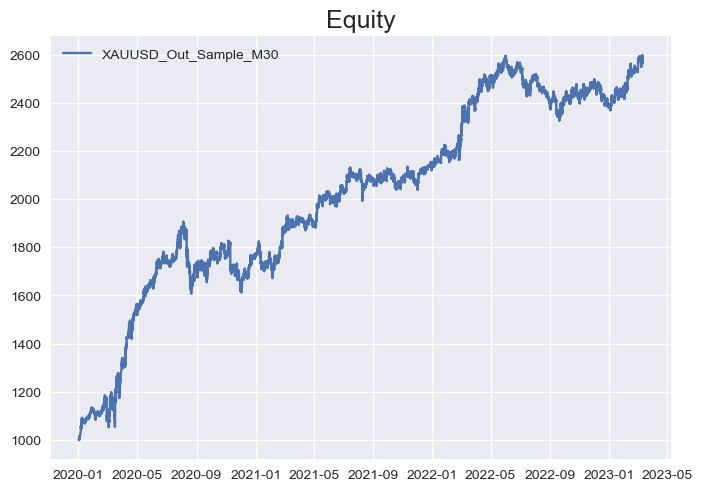

In [214]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [215]:
filename_train = f'result_{TF}_In_Sample.csv'

In [216]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [217]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [218]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M15

In [219]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [220]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [221]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [222]:
train

Start                     2014-09-23 14:30:00
End                       2020-12-31 21:30:00
Duration                   2291 days 07:00:00
Exposure Time [%]                   99.998651
Equity Final [$]                     2879.817
Equity Peak [$]                      2912.561
Return [%]                           187.9817
Buy & Hold Return [%]               55.396129
Return (Ann.) [%]                    14.64428
Volatility (Ann.) [%]               12.721767
Sharpe Ratio                          1.15112
Sortino Ratio                        1.985095
Calmar Ratio                         0.910397
Max. Drawdown [%]                  -16.085599
Avg. Drawdown [%]                    -0.36162
Max. Drawdown Duration      393 days 19:30:00
Avg. Drawdown Duration        2 days 00:25:00
# Trades                                67893
Win Rate [%]                        60.202083
Best Trade [%]                       2.035179
Worst Trade [%]                     -3.427653
Avg. Trade [%]                    

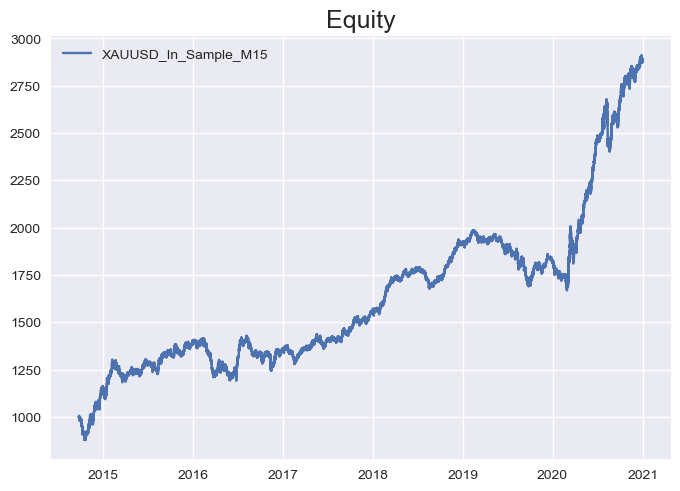

In [223]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [224]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     2911.657
Equity Peak [$]                      2952.835
Return [%]                           191.1657
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                   31.378293
Volatility (Ann.) [%]               20.570727
Sharpe Ratio                         1.525386
Sortino Ratio                        3.154497
Calmar Ratio                         1.877581
Max. Drawdown [%]                  -16.712082
Avg. Drawdown [%]                   -0.450541
Max. Drawdown Duration      254 days 08:15:00
Avg. Drawdown Duration        1 days 13:32:00
# Trades                                34868
Win Rate [%]                        60.462315
Best Trade [%]                       2.035179
Worst Trade [%]                     -3.472768
Avg. Trade [%]                    

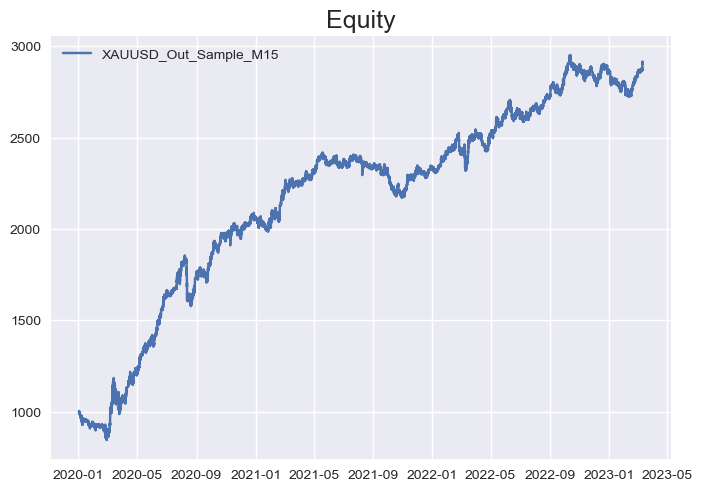

In [225]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [226]:
filename_train = f'result_{TF}_In_Sample.csv'

In [227]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [228]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [229]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M5

In [230]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [231]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [232]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [233]:
train

Start                     2020-05-15 11:40:00
End                       2023-03-10 17:50:00
Duration                   1029 days 06:10:00
Exposure Time [%]                      99.999
Equity Final [$]                      5423.47
Equity Peak [$]                      5435.983
Return [%]                            442.347
Buy & Hold Return [%]                7.622745
Return (Ann.) [%]                   62.217588
Volatility (Ann.) [%]               16.117706
Sharpe Ratio                         3.860201
Sortino Ratio                       13.331574
Calmar Ratio                         6.790749
Max. Drawdown [%]                   -9.162109
Avg. Drawdown [%]                   -0.144932
Max. Drawdown Duration       82 days 11:10:00
Avg. Drawdown Duration        0 days 08:07:00
# Trades                               113591
Win Rate [%]                        61.635165
Best Trade [%]                          1.128
Worst Trade [%]                     -2.698002
Avg. Trade [%]                    

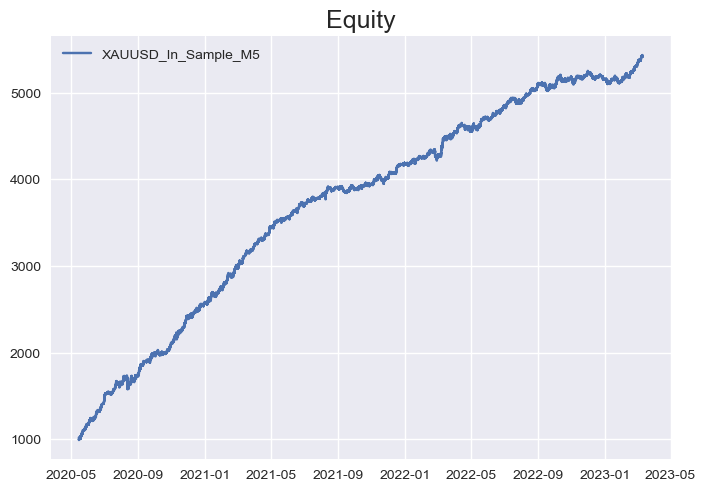

In [234]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [235]:
test

Start                     2023-01-02 23:30:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:25:00
Exposure Time [%]                   99.985063
Equity Final [$]                     1263.531
Equity Peak [$]                      1275.348
Return [%]                            26.3531
Buy & Hold Return [%]                1.999557
Return (Ann.) [%]                  172.849244
Volatility (Ann.) [%]               57.580464
Sharpe Ratio                         3.001873
Sortino Ratio                       13.734942
Calmar Ratio                        20.433498
Max. Drawdown [%]                   -8.459112
Avg. Drawdown [%]                   -0.299514
Max. Drawdown Duration       18 days 07:55:00
Avg. Drawdown Duration        0 days 06:45:00
# Trades                                 7637
Win Rate [%]                        61.830562
Best Trade [%]                       0.473524
Worst Trade [%]                     -1.354524
Avg. Trade [%]                    

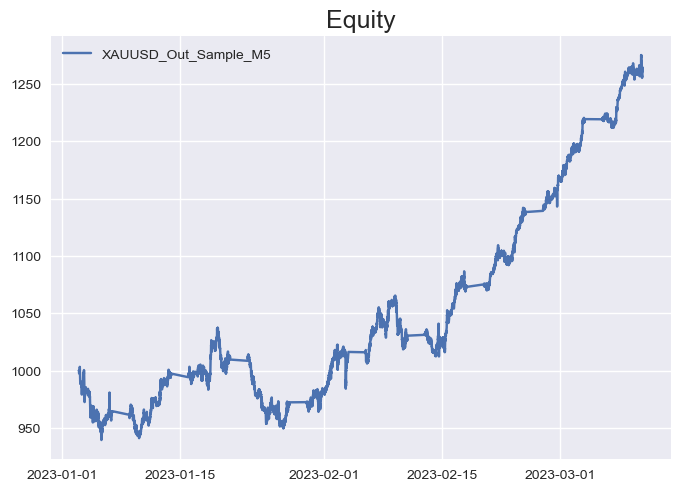

In [236]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [237]:
filename_train = f'result_{TF}_In_Sample.csv'

In [238]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [239]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [240]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M1

In [241]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [242]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [243]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_25240\2957458901.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [244]:
train

Start                     2022-08-16 23:19:00
End                       2023-03-10 17:58:00
Duration                    205 days 18:39:00
Exposure Time [%]                      99.999
Equity Final [$]                     1721.678
Equity Peak [$]                      1726.439
Return [%]                            72.1678
Buy & Hold Return [%]                 4.98525
Return (Ann.) [%]                  117.644149
Volatility (Ann.) [%]               40.089322
Sharpe Ratio                         2.934551
Sortino Ratio                       13.969165
Calmar Ratio                        15.414109
Max. Drawdown [%]                   -7.632238
Avg. Drawdown [%]                   -0.159539
Max. Drawdown Duration       42 days 05:32:00
Avg. Drawdown Duration        0 days 04:27:00
# Trades                                72257
Win Rate [%]                        58.603319
Best Trade [%]                       0.956342
Worst Trade [%]                     -0.953713
Avg. Trade [%]                    

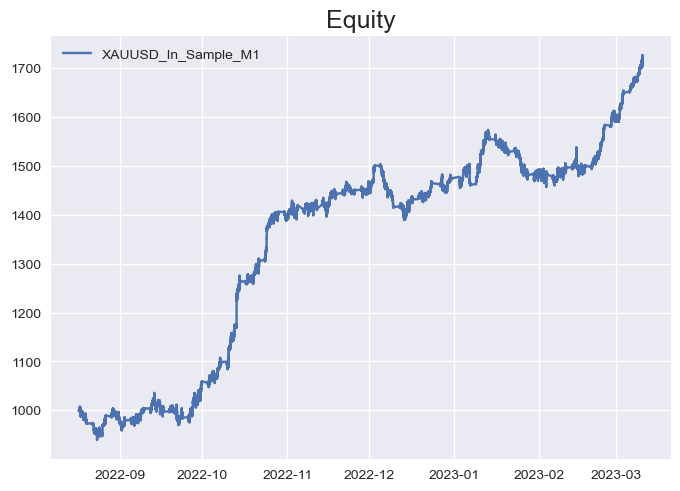

In [245]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [246]:
test

Start                     2023-01-02 23:08:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:51:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1246.493
Equity Peak [$]                      1251.614
Return [%]                            24.6493
Buy & Hold Return [%]                1.903539
Return (Ann.) [%]                  163.042204
Volatility (Ann.) [%]               58.963989
Sharpe Ratio                         2.765115
Sortino Ratio                       13.714038
Calmar Ratio                        15.298873
Max. Drawdown [%]                  -10.657138
Avg. Drawdown [%]                   -0.160796
Max. Drawdown Duration       42 days 05:32:00
Avg. Drawdown Duration        0 days 03:29:00
# Trades                                24273
Win Rate [%]                        59.102707
Best Trade [%]                       0.891826
Worst Trade [%]                      -0.86035
Avg. Trade [%]                    

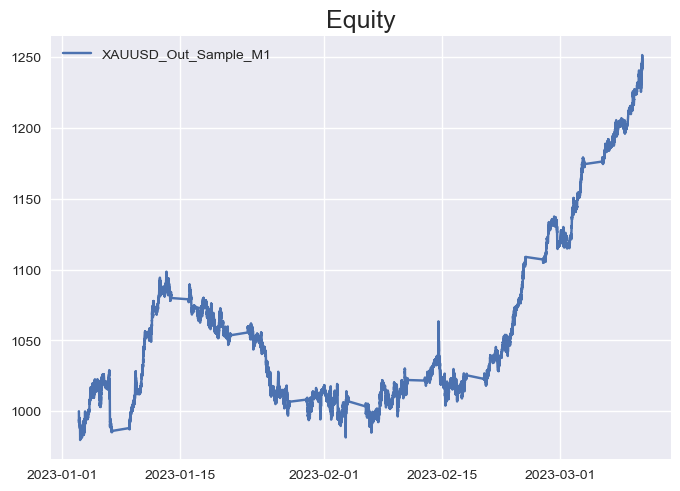

In [247]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [248]:
filename_train = f'result_{TF}_In_Sample.csv'

In [249]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')